In [6]:
!unzip test_dataset/Тестовый\ датасет\ \(2\).zip -d test_dataset/

Archive:  test_dataset/Тестовый датасет (2).zip
  inflating: test_dataset/2.docx     
  inflating: test_dataset/3.docx     
  inflating: test_dataset/4.docx     
  inflating: test_dataset/5.docx     
  inflating: test_dataset/6.docx     
  inflating: test_dataset/7.docx     
  inflating: test_dataset/8.docx     
  inflating: test_dataset/9.docx     
  inflating: test_dataset/10.docx    
  inflating: test_dataset/Название_команды.csv  
  inflating: test_dataset/Пояснения к валидации.docx  
  inflating: test_dataset/1.docx     


In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

import pandas as pd
import docx
import os
import re

device = 'cuda'

/home/ubuntu/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#word preprocessing functions

import nltk
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

russian_stopwords = stopwords.words("russian")

russian_stopwords.append('российской')
russian_stopwords.append('федерации')
russian_stopwords.append('федерального')
russian_stopwords.append('настоящих')
russian_stopwords.append('соответствии')
russian_stopwords.append('также')
russian_stopwords.append('рф')
russian_stopwords.append('ред')

russian_stopwords.append('субсидии')
russian_stopwords.append('предоставления')


def lowercase(text):
    return str(text).lower()

def clean_symb(text):
    return re.sub(r'[^\w]', ' ', text)

def clear_token(text):
    return word_tokenize(text)

def clean_stopwords(token):
    return ' '.join([i for i in token.split(' ') if i not in russian_stopwords])

def clean_stem(token):
    return [st.stem(i) for i in token]

### combo 3 prev
def make_clean(s):
    return ' '.join(clean_stem(clean_stopwords(clear_token(s))))

In [4]:
#find all docs

data_path = './test_dataset/'
documents = os.listdir(data_path)
documents = [data_path+d for d in documents]
len(documents)

11

In [5]:
#load and parse doc functions

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize


def get_text(filename):
    doc = docx.Document(filename)
    fullText = ''
    for para in doc.paragraphs:
         for run in para.runs:
            fullText+=run.text
            fullText+='\n'
    return fullText

def split_text(text):
    texts, groups = [],[]
    regt = re.findall(r"{(.*?)}(.*?){(.*?)}",text.replace('\n',''))
    for t in regt:
        if t[0]==t[-1]:
            texts.append(t[1])
            groups.append(int(t[0]))
        else:
            print(t)
            
    return texts, groups

In [6]:
#load data

all_text, all_groups, doc_paths, doc_names = [],[],[],[]
for d in documents:
    if 'ipynb' not in d:
        text = get_text(d)
        texts,groups = split_text(text)
        all_text.extend(texts)
        all_groups.extend(groups)
        doc_paths.extend([d for a in range(len(texts))])
        doc_names.extend([d.split('/')[-1] for a in range(len(texts))])

('66', '18. ', '67')
('67', '', '68')
('68', '', '69')
('69', '', '70')
('Q = (К1 x ГС1) + (К2 x ГС1),где:{42', 'К1 - кандидаты на назначение государственных стипендий, являющиеся молодыми (до 35 лет включительно) творческими деятелями в области культуры и искусства;', '42')


In [41]:
#load documents
#apply preprocessing to documents

df = pd.DataFrame([doc_paths, doc_names,all_text, all_groups]).T
df.columns = ['path','doc','text','id']
df['r_text']='r'
df['r_text'] = df.text.apply(lowercase)
df['r_text'] = df.r_text.apply(clean_symb)
df['r_text'] = df.r_text.apply(lambda x:''.join([a for a in x if not a.isdigit()]))
df['r_text'] = df.r_text.apply(lambda x:' '.join([a for a in x.split(' ') if len(a)>1]))
df['r_text'] = df.r_text.apply(clean_stopwords)
df['text_size'] = df['text'].apply(lambda x: len(x.strip()))
df['is_text'] = df.r_text.apply(lambda x:x.strip().isdigit())
df = df[~df.is_text]
df = df[df['text_size']>5]
df = df.reset_index(drop=True)
df.shape

(846, 7)

In [42]:
#show most popular words in datset

all_words = np.hstack([np.array(a) for a in df.r_text.apply(lambda x:[a for a in x.split(' ') if len(a)>0]).values])
pd.Series(all_words).value_counts()[:10]

правил            175
организации       155
предоставлении    123
соглашения        115
конкурса           90
министерством      85
средств            82
финансового        79
числе              76
заявок             74
dtype: int64

In [43]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

from bert_dataset import CustomDataset

In [11]:
#load model
model = torch.load('bert_opossum_best_0.6753.pt')
model.to(device)
pass

#load tokenizer
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base')

In [44]:
#predict function
def predict(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    out = {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten()
      }
    
    input_ids = out["input_ids"].to(device)
    attention_mask = out["attention_mask"].to(device)

    outputs = model(
        input_ids=input_ids.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0)
    )

    prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
    return prediction

In [49]:
#apply predict funtcion to text
df['class'] = df.r_text.progress_apply(predict)

100%|█████████████████████████████████████████| 846/846 [00:29<00:00, 28.49it/s]


In [50]:
#get file_id
df['file_id'] = df.doc.apply(lambda x:int(x.split('.')[0]))

In [80]:
#create submission

pred = df[['file_id','id','class']]
sub = pd.read_csv('Название_команды.csv',delimiter=';')
sub = pd.merge(sub,pred,how='left',on=['file_id','id'])
sub.drop(columns=['class_x'],inplace=True)
sub.columns = ['file_id','id','class']
sub = sub.fillna(23).astype(int)
sub['class']+=1
sub

,file_id,id,class
0,1,1,2
1,1,2,2
2,1,3,2
3,1,4,3
4,1,5,7
...,...,...,...
847,10,67,38
848,10,68,38
849,10,69,38
850,10,70,38


In [94]:
#save submission data
sub.to_csv('MAGNUM_OPOSSUM.csv',index=False,header=True,sep=';')

<AxesSubplot:xlabel='class', ylabel='id'>

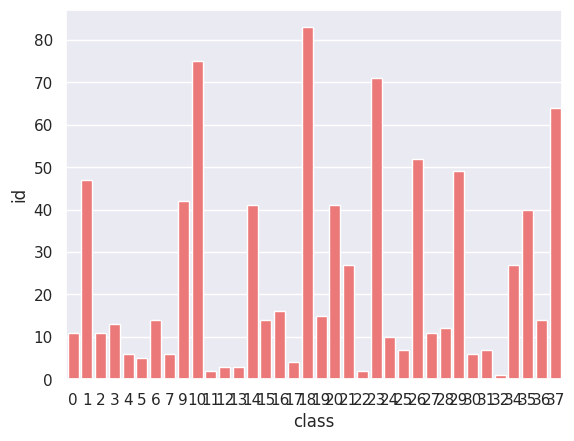

In [38]:
#show class distribution

f = sub.groupby('class').count().reset_index()[['class','id']]
f['class'] = f['class']-1

sns.barplot(x=f['class'],y=f['id'],color='#ff6666',errwidth=.32)